# Setup

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from xgboost import XGBRegressor, plot_importance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.layers import concatenate as Concatenate
from tensorflow.keras.optimizers import Adam

from NN_functions import *

# NN Model

In [20]:
# Create and train the model

random_state = 3
nodes = 3

X, y = import_data()
X_train_lin, X_test_lin, X_train_sig, X_test_sig, y_train, y_test, scaler_y = split_data(X, y, random_state)
model = create_model(nodes)

history = model.fit([X_train_lin, X_train_sig], y_train, batch_size=16,
                    epochs=1000, validation_split=0.25, shuffle=True, verbose=0)
plot_model_history(history)

In [53]:
# Get NN predictions

y_train_nn = model.predict([X_train_lin, X_train_sig], batch_size=10, verbose=0)
y_train_nn = scaler_y.inverse_transform(y_train_nn).reshape(-1)
y_test_nn = model.predict([X_test_lin, X_test_sig], batch_size=10, verbose=0)
y_test_nn = scaler_y.inverse_transform(y_test_nn).reshape(-1)

# Boost Residuals

In [15]:
Boosting_data = pd.read_csv("Data/BoostingData.csv")

random_state = 3

X = Boosting_data.values[:,3:]
y = Boosting_data.values[:,2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train = np.asarray(X_train.astype("float32"))
X_test = np.asarray(X_test.astype("float32"))

In [57]:
# Calculate residuals
e_train_nn = y_train - y_train_nn
e_test_nn = y_test - y_test_nn

# Decision Tree for Residuals
bdt = XGBRegressor(n_estimators=100,max_depth=3,learning_rate=0.1,colsample_bytree=0.8, subsample=0.8)
bdt.fit(X_train, e_train_nn)
e_train_boost = bdt.predict(X_train)
e_test_boost = bdt.predict(X_test)

# Get updated predictions
y_train_boost = y_train_nn + e_train_boost
y_test_boost = y_test_nn + e_test_boost

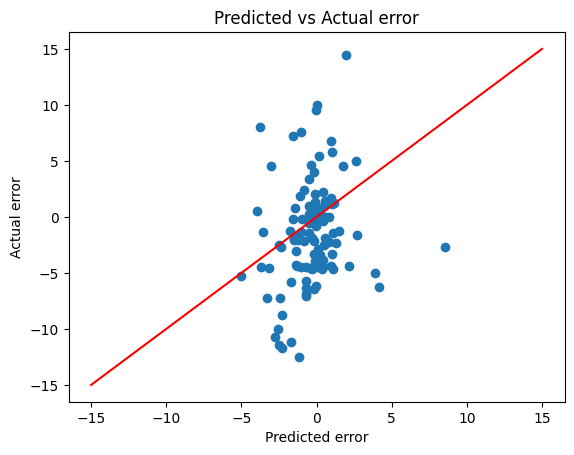

In [70]:
# Plot predicted residuals
plt.scatter(e_test_boost, e_test_nn)
#plt.xlim(-10,20)
#plt.ylim(-10,20)
plt.plot(np.arange(-15, 16), np.arange(-15,16), color= "r")
plt.xlabel('Predicted error') 
plt.ylabel('Actual error')
plt.title("Predicted vs Actual error")
plt.savefig("Plots/boosting_residuals_predicted_vs_actual")
plt.show()

# Results

In [75]:
# Get statistics

rmse_train_nn = np.sqrt(MSE(y_train, y_train_nn))
mae_train_nn = MAE(y_train, y_train_nn)
mape_train_nn = MAPE(y_train, y_train_nn)

rmse_test_nn = np.sqrt(MSE(y_test, y_test_nn))
mae_test_nn = MAE(y_test, y_test_nn)
mape_test_nn = MAPE(y_test, y_test_nn)

rmse_train_boost = np.sqrt(MSE(y_train, y_train_boost))
mae_train_boost = MAE(y_train, y_train_boost)
mape_train_boost = MAPE(y_train, y_train_boost)

rmse_test_boost = np.sqrt(MSE(y_test, y_test_boost))
mae_test_boost = MAE(y_test, y_test_boost)
mape_test_boost = MAPE(y_test, y_test_boost)

print(f"NN Training RMSE = {np.round(rmse_train_nn, 2)}")
print(f"Boosting Training RMSE = {np.round(rmse_train_boost, 2)}")
print(f"NN Training MAE = {np.round(mae_train_nn, 2)}")
print(f"Boosting Training MAE = {np.round(mae_train_boost, 2)}")
print(f"NN Training MAPE = {np.round(mape_train_nn, 4):.2%}")
print(f"Boosting Training MAPE = {np.round(mape_train_boost, 4):.2%}")
print("")
print(f"NN Testing RMSE = {np.round(rmse_test_nn, 2)}")
print(f"Boosting Testing RMSE = {np.round(rmse_test_boost, 2)}")
print(f"NN Testing MAE = {np.round(mae_test_nn, 2)}")
print(f"Boosting Testing MAE = {np.round(mae_test_boost, 2)}")
print(f"NN Testing MAPE = {np.round(mape_test_nn, 4):.2%}")
print(f"Boosting Testing MAPE = {np.round(mape_test_boost, 4):.2%}")

NN Training RMSE = 5.03
Boosting Training RMSE = 3.68
NN Training MAE = 4.0
Boosting Training MAE = 2.95
NN Training MAPE = 1.46%
Boosting Training MAPE = 1.09%

NN Testing RMSE = 4.91
Boosting Testing RMSE = 4.79
NN Testing MAE = 3.8
Boosting Testing MAE = 3.63
NN Testing MAPE = 1.37%
Boosting Testing MAPE = 1.30%


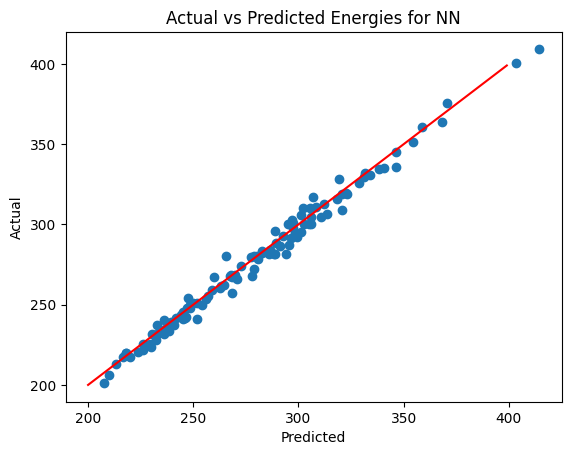

In [60]:
# Results before boosting

plt.scatter(y_test_nn, y_test)
plt.plot(np.arange(200,400), np.arange(200,400), color = "r")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Actual vs Predicted Energies for NN")
plt.savefig("Plots/nn_results_before_boosting")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


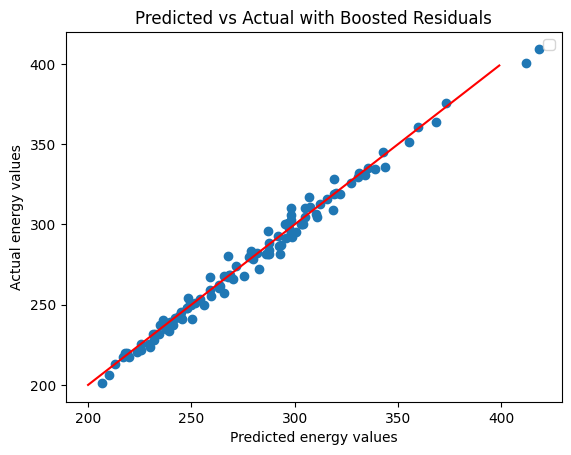

In [61]:
# Results after boosting
plt.scatter(y_test_boost, y_test)
plt.plot(np.arange(200, 400), np.arange(200,400), color= "r")
plt.xlabel('Predicted energy values') 
plt.ylabel('Actual energy values')
plt.title("Predicted vs Actual with Boosted Residuals")
plt.savefig("Plots/nn_with_boosting_results")
plt.show()

# Test Model with Cross Validation

In [43]:
Boosting_data = pd.read_csv("Data/BoostingData.csv")
X = Boosting_data.values[:,3:]
y = Boosting_data.values[:,2]

df_nn_preds = pd.read_csv("Results/nn_Preds_100_10pct_full.csv")

num_of_trials = 100

random_state_list = np.zeros(num_of_trials, dtype=int)
rmse_train_list = np.zeros(num_of_trials)
mae_train_list = np.zeros(num_of_trials)
mape_train_list = np.zeros(num_of_trials)
rmse_test_list = np.zeros(num_of_trials)
mae_test_list = np.zeros(num_of_trials)
mape_test_list = np.zeros(num_of_trials)


for i in tqdm.tqdm(range(num_of_trials)):
        # i is the random_state
        rand_state = i
        random_state_list[i] = rand_state

        # Perform splitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rand_state)
        X_train = np.asarray(X_train.astype("float32"))
        X_test = np.asarray(X_test.astype("float32"))

        # Calculate residuals
        y_train_nn = np.asarray(df_nn_preds[f"train_{rand_state}"])
        y_test_nn = np.asarray(df_nn_preds[f"test_{rand_state}"])[:len(y_test)]
        e_train_nn = y_train - y_train_nn
        e_test_nn = y_test - y_test_nn

        # Decision Tree for Residuals
        bdt = XGBRegressor(n_estimators=150,max_depth=5,learning_rate=0.1,colsample_bytree=0.8, subsample=0.8)
        bdt.fit(X_train, e_train_nn)
        e_train_boost = bdt.predict(X_train)
        e_test_boost = bdt.predict(X_test)

        # Get updated predictions
        y_train_boost = y_train_nn + e_train_boost
        y_test_boost = y_test_nn + e_test_boost

       # Calculate the train and test statistics
        rmse_train = np.sqrt(MSE(y_train, y_train_boost))
        mae_train = MAE(y_train, y_train_boost)
        mape_train = MAPE(y_train, y_train_boost)
        
        rmse_test = np.sqrt(MSE(y_test, y_test_boost))
        mae_test = MAE(y_test, y_test_boost)
        mape_test = MAPE(y_test, y_test_boost)

        # Put the train and test statistics in the lists
        rmse_train_list[i] = rmse_train
        mae_train_list[i] = mae_train
        mape_train_list[i] = mape_train

        rmse_test_list[i] = rmse_test
        mae_test_list[i] = mae_test
        mape_test_list[i] = mape_test

df_stats = pd.DataFrame({
        "Random State":random_state_list,
        "RMSE Train":rmse_train_list,
        "MAE Train":mae_train_list,
        "MAPE Train":mape_train_list,
        "RMSE Test":rmse_test_list,
        "MAE Test":mae_test_list,
        "MAPE Test":mape_test_list
})

df_stats.to_csv("Results/boost_TrainTest_100_10pct.csv") 

100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


In [44]:
df_stats

,Random State,RMSE Train,MAE Train,MAPE Train,RMSE Test,MAE Test,MAPE Test
0,0,1.842644,1.421109,0.005293,4.960122,3.733971,0.013711
1,1,1.752512,1.357541,0.005038,4.559242,3.768733,0.013809
2,2,1.795455,1.403583,0.005234,4.751377,3.803375,0.014037
3,3,1.812669,1.422778,0.005303,4.652063,3.525882,0.012782
4,4,1.765382,1.398979,0.005192,5.068683,4.225196,0.015570
...,...,...,...,...,...,...,...
95,95,1.781731,1.397682,0.005185,4.356322,3.340581,0.012272
96,96,1.742387,1.362428,0.005066,4.955357,4.029213,0.014569
97,97,1.762926,1.375106,0.005126,4.566004,3.545199,0.013057
98,98,1.715060,1.343288,0.004999,4.003104,3.246804,0.012233
